In [44]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Manifold Learning

In [21]:
bean_df = pd.read_excel("./Datasets/Dry_Bean_Dataset.xlsx")
X_train, X_test, Y_train, Y_test = train_test_split(bean_df.iloc[:,:-1], bean_df.iloc[:,-1], shuffle = True, test_size = 0.2, random_state = 42)   
colors = Y_test.astype('category').cat.codes

## PCA

In [24]:
class My_PCA():
    def __init__(self):
        self.U = None
        self.L = None
        self.mean = None


    def fit(self, X):
        #Compute the covariance matrix. 
        X_ = np.asarray(X)
        self.mean = np.mean(X_, axis=0)
        X_c = X_ - self.mean
        C = (X_c.T @ X_c) / (X_c.shape[0] - 1)
        self.L, self.U = np.linalg.eigh(C)

        idx = np.argsort(self.L)[::-1]
        self.L = self.L[idx]
        self.U = self.U[:,idx]

        return self.L, self.U
    
    def transform(self, X, d):
        X_ = np.asarray(X)
        X_c = X_-self.mean
        return X_c @ self.U[:,:d]
    
my_pca = My_PCA()
sk_pca = PCA(2)

L, U = my_pca.fit(X_train)
my_comp = my_pca.transform(X_test, 2)

sk_pca.fit(X_train)
sk_comp = sk_pca.transform(X_test)

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=("Eigenvalues (Variance)", "Sklearn PCA", "My PCA")
)

fig.add_trace(
    go.Scatter(x=np.arange(len(L)), y=L, mode='lines+markers', name="Autovalori"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=sk_comp[:, 0], y=sk_comp[:, 1], 
        mode='markers', 
        marker=dict(color=colors, colorscale='Viridis'),
        name="Sklearn"
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=my_comp[:, 0], y=my_comp[:, 1], 
        mode='markers', 
        marker=dict(color=colors, colorscale='Viridis'),
        name="My PCA"
    ),
    row=1, col=3
)

# Aggiornamento layout per titoli e dimensioni
fig.update_layout(
    height=500, 
    width=1500, 
    title_text="PCA Comparison",
    showlegend=False
)

fig.show()

## KernellPCA

In [4]:
class My_KernelPCA():
    def __init__(self, kernel):
        self.scale = None
        self.U = None
        self.Tr = None
        self.K_row_mean = None
        self.kernel = kernel
        self.args = None

    def fit(self, X, *args):
        #Save the training data and compute the kernel
        self.args = args
        self.Tr = np.asarray(X)
        K = self.kernel(self.Tr, self.Tr, *self.args)
        n = K.shape[0]

        #Double center
        self.K_row_mean = np.mean(K, axis=0)
        total_avg = np.mean(K)

        #Simmetric matrix so row mean and column mean equal
        K_centered = K - self.K_row_mean[None, :] - self.K_row_mean[:, None] + total_avg

        #Decomposition
        self.L, self.U = np.linalg.eigh(K_centered)
        idx = np.argsort(self.L)[::-1]
        self.L = self.L[idx]
        self.U = self.U[:,idx]
        
        # scale factor
        self.scale = 1.0 / np.sqrt(np.maximum(self.L, 1e-10))

    def transform(self, X, d):
        X = np.asarray(X)
        K = self.kernel(X, self.Tr, *self.args)

        K_row_mean = np.mean(K, axis=1, keepdims=True)
        K_center = K - self.K_row_mean - K_row_mean + np.mean(self.K_row_mean)
        
        return K_center @ (self.U[:,:d] * self.scale[:d])

In [5]:
def rbf_kernel(X1, X2, gamma=0.1):
    sq_dist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * (X1 @ X2.T)
    return np.exp(-gamma * np.maximum(sq_dist, 0))

my_kpca = My_KernelPCA(rbf_kernel)
my_kpca.fit(X_train[:500], 0.000001) 
my_proj = my_kpca.transform(X_train[:500], 2)

sk_kpca = KernelPCA(2, kernel='rbf', gamma=0.000001)
sk_proj = sk_kpca.fit_transform(X_train[:500])

color_codes = Y_train[:500].astype('category').cat.codes

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("My KernelPCA", "SkLearn")
)
fig.add_trace(
    go.Scatter(
        x=my_proj[:, 0], y=my_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="MDS"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=sk_proj[:, 0], y=sk_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="PCA"
    ),
    row=1, col=2
)

fig.update_layout(
    height=600, 
    width=1200, 
    title_text="MDS vs PCA",
    template="plotly_white"
)

fig.show()


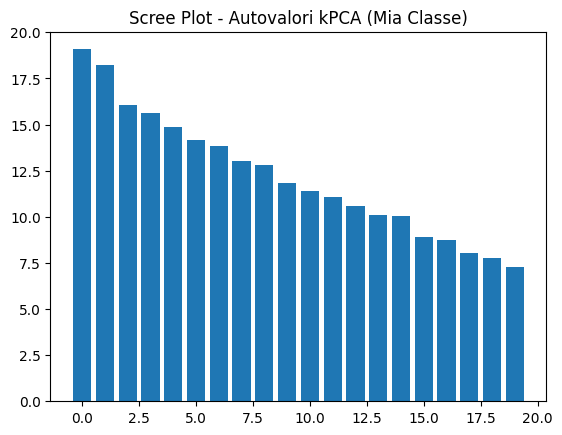

In [6]:
plt.bar(range(len(my_kpca.L[:20])), my_kpca.L[:20])
plt.title("Scree Plot - Autovalori kPCA (Mia Classe)")
plt.show()

## MDS

In [23]:
class My_MDS():
    def __init__(self, dist):
        self.dist = dist
    
    def transform(self,d, *args):
        #Compute distance matrix
        Theta = self.dist(*args)
        n = Theta.shape[0]
        
        #Compute the graham matrix
        J = np.eye(n) - np.ones((n,n))/n
        G = -0.5 * (J @ (Theta**2) @ J)

        #Perform the eigenvalue decomposition
        L, U = np.linalg.eigh(G)

        #Sort eigenvalue and eigenvector
        idx = np.argsort(L)[::-1]
        L = L[idx]
        U = U[:,idx]

        L_d = np.maximum(L[:d], 0)
        return U[:, :d] @ np.diag(np.sqrt(L_d))

### PCA
The formula is $\text{dist}^2_{ij} = \|x_i\|^2 + \|x_j\|^2 - 2 \langle x_i, x_j \rangle$

In [ ]:
def euclidean_dist(X):
    X = np.asarray(X)

    sq_norm = np.sum(X**2, axis=1).reshape(-1,1)


    #The sum compose a matrix with all the combination sum of Xi and Xj. the second part subtract the scalar products.
    dist_sq = sq_norm + sq_norm.T - 2*(X @ X.T)
    dist_sq = np.maximum(dist_sq, 0)
    
    return np.sqrt(dist_sq)

mds_pca = My_MDS(euclidean_dist)
mds_proj = mds_pca.transform(2, X_train[:500])

my_pca = My_PCA()
my_pca.fit(X_train[:500])
my_proj = my_pca.transform(X_train[:500], 2)

color_codes = Y_train[:500].astype('category').cat.codes

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("MDS (Euclidean)", "PCA")
)
fig.add_trace(
    go.Scatter(
        x=mds_proj[:, 0], y=mds_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="MDS"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=my_proj[:, 0], y=my_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="PCA"
    ),
    row=1, col=2
)

fig.update_layout(
    height=600, 
    width=1200, 
    title_text="MDS vs PCA",
    template="plotly_white"
)

fig.show()

### Isomap

In [9]:
def geodesic_dist(X, d):
    X = np.asarray(X)
    #Calculate the euclidean distance
    Eu = euclidean_dist(X)

    #Compute the neigbourhood graph
    idx = np.argpartition(Eu, d, axis=1)
    to_mask = idx[:, d:]
    rows = np.arange(Eu.shape[0])[:, None]
    Eu[rows, to_mask] = np.inf

    #Compute the distance matrix
    Theta = shortest_path(Eu, method='auto', directed=False)
    return Theta

my_iso = My_MDS(geodesic_dist)
mds_proj = my_iso.transform(2, X_train[:500],10)

sk_iso = Isomap(n_components=2, n_neighbors=10)
sk_proj = sk_iso.fit_transform(X_train[:500])

color_codes = Y_train[:500].astype('category').cat.codes

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("MDS (Geodesic)", "SkLearn")
)
fig.add_trace(
    go.Scatter(
        x=mds_proj[:, 0], y=mds_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="MDS"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=sk_proj[:, 0], y=sk_proj[:, 1], 
        mode='markers', 
        marker=dict(
            color=color_codes, 
            colorscale='Viridis',
            showscale=False
        ),
        text=Y_train[:500],
        name="PCA"
    ),
    row=1, col=2
)

fig.update_layout(
    height=600, 
    width=1200, 
    title_text="MY vs SkLearn",
    template="plotly_white"
)

fig.show()

### Diffusion Maps

In [17]:
def diffusion_dist(X, sigma = None):
    # Get eu dist
    dist = euclidean_dist(X)**2

    if sigma is None:
        sigma = np.median(dist)
        print(sigma)
    # Compute K
    K = np.exp(-dist / (2*sigma**2))

    # Normalize
    row_sum = np.sum(K, axis=1)
    K = K / (np.sqrt(row_sum.reshape(-1, 1) @ row_sum.reshape(1, -1)))

    #Compute transition matrix
    row_sum = np.sum(K, axis=1)
    return K / row_sum.reshape(-1, 1)

my_iso = My_MDS(diffusion_dist)
mds_proj = my_iso.transform(2, X_train[:500], None)

color_codes = Y_train[:500].astype('category').cat.codes

plot_df = pd.DataFrame({
    'Dim 1': mds_proj[:, 0],
    'Dim 2': mds_proj[:, 1],
    'Classe': Y_train[:500].values 
})

fig = px.scatter(plot_df, x='Dim 1', y='Dim 2', color='Classe',
                 title="Diffusion Maps + MDS (Dry Bean Dataset)",
                 template="plotly_white",
                 opacity=0.7)

fig.show()


509693256.8959113


# Intrinsic Dimension Estimation

## Nearest Neighbours

In [41]:
class TWO_NN():

    def __init__(self,X):
        eu = euclidean_dist(X)
        eu = np.sort(eu, axis=1)
        r_1 = eu[:,1]
        r_2 = eu[:,2]

        mask = r_1 > 1e-10 
        r1_valid = r_1[mask]
        r2_valid = r_2[mask]
        self.mu = r2_valid / r1_valid
        self.mu = self.mu[self.mu > 1]
        self.N = len(self.mu)

    def log_likelihood(self):
        return self.N/sum(np.log(self.mu))
    
    def empirical(self):
        mu = np.sort(self.mu)[:-1]
        F = np.arange(1, self.N + 1) / self.N
        Y = -np.log(1-F[:-1])
        X = np.log(mu)
        return np.sum(X*Y)/np.sum(X**2)


In [42]:
two_nn = TWO_NN(X_train)

print(f"Likelihood ID: {two_nn.log_likelihood():.4f}")
print(f"Empirical ID:  {two_nn.empirical():.4f}")

Likelihood ID: 2.8211
Empirical ID:  2.8910


# Density Estimation

## Gaussian Mixture Models

Log-Likelihood (Mia):    31.8902
Log-Likelihood (Sklearn): 17.9150
Differenza: 13.9753


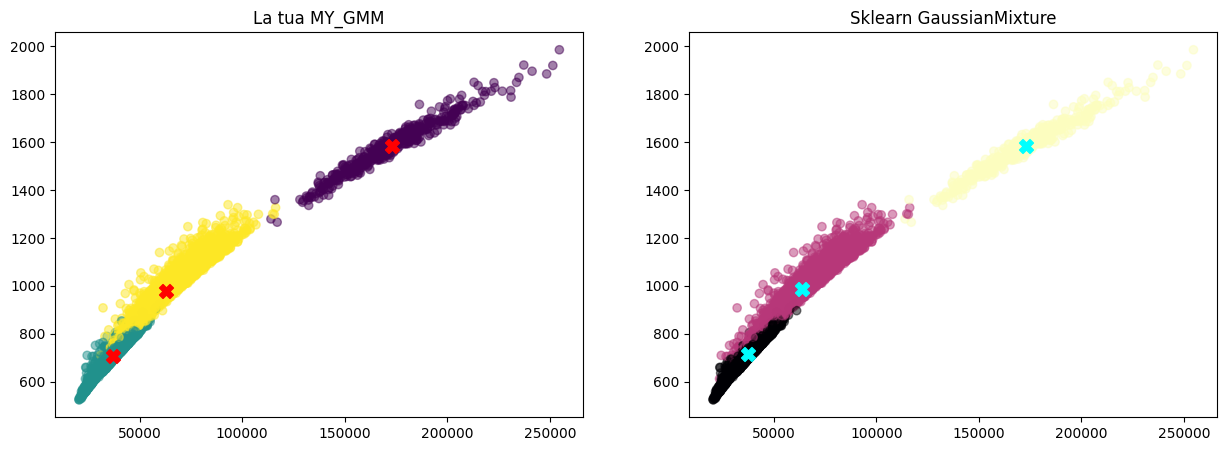

In [79]:
class MY_GMM():
    def __init__(self, d):
        self.pi = np.full(d, 1/d)
        self.mu = None
        self.sigma = None
        self.N = None
        self.d = d
    
    def Initialize_mu_sigma(self, X):
        self.mu = np.zeros((self.d, X.shape[1]))
        self.N = X.shape[0]
        var = np.var(X, axis=0)
        self.sigma = np.array([np.diag(var) for _ in range(self.d)])
        idx = np.random.choice(X.shape[0], size=self.d, replace=False)
        centers = X[idx]

        for i in range(10):
            sq_c = np.sum(centers**2, axis=1).reshape(-1, 1)
            sq_x = np.sum(X**2, axis=1)
            dot = centers @ X.T
            eu = np.sqrt(np.maximum(sq_c + sq_x - 2*dot, 0))

            cl = np.argmin(eu, axis=0)

            for i in range(self.d):
                idx = np.where(cl==i)
                self.mu[i] = np.mean(X[idx], axis=0)
                
            centers = self.mu

    def compute_gaussian(self,X,k):
        c_x = X-self.mu[k]
        sig_inv = np.linalg.inv(self.sigma[k])
        det = np.linalg.det(self.sigma[k])

        den = np.sqrt((2*np.pi)**X.shape[1] * det)
        exp = np.exp(-0.5 * np.sum((c_x @ sig_inv) * c_x, axis=1))

        return (1/den) * exp


    def compute_expectation(self, X):
        joint = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            joint[:, k] = self.pi[k] * self.compute_gaussian(X, k)

        return joint/np.sum(joint, axis=1, keepdims=True) 
    
    def update_params(self, exp, X):
        N, D = X.shape
        n_k = np.sum(exp, axis=0)
        self.pi = n_k / N

        for k in range(self.d):
            gamma_k = exp[:, k].reshape(-1, 1)
            self.mu[k] = np.sum(gamma_k * X, axis=0) / n_k[k]
            diff = X - self.mu[k] 
            self.sigma[k] = ( (gamma_k * diff).T @ diff ) / n_k[k]

    def compute_log_likelihood(self, X):
        weighted_probs = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            weighted_probs[:, k] = self.pi[k] * self.compute_gaussian(X, k)
        total_probs = np.sum(weighted_probs, axis=1)
        log_likelihood = np.sum(np.log(total_probs + 1e-10))
        
        return log_likelihood
        
    def fit(self, X, eps=1e-6, max_it=1000, delta=np.inf):
        X = np.asarray(X)
        log_likelihoods = []
        it = 0
        self.Initialize_mu_sigma(X)
        curr_log = self.compute_log_likelihood(X)

        while delta > eps and it < max_it:
            prev_log = curr_log
            exp = self.compute_expectation(X)
            self.update_params(exp, X)
            curr_log = self.compute_log_likelihood(X)
            delta = np.abs(curr_log - prev_log)

    def predict(self, X):
        X = np.asarray(X)
        exp = self.compute_expectation(X)
        return np.argmax(exp, axis=1)
    
    def score_samples(self, X):
        X = np.asarray(X)
        w_probs = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            w_probs[:, k] = self.pi[k] * self.compute_gaussian(X, k)
        total_probs = np.sum(w_probs, axis=1)
        return np.log(total_probs + 1e-10)
    
X = np.asarray(X_train)

sk_gmm = GaussianMixture(n_components=3, tol=1e-6, max_iter=1000, random_state=42)
sk_gmm.fit(X)

my_gmm = MY_GMM(d=3)
my_gmm.fit(X, eps=1e-6, max_it=1000)

my_ll = my_gmm.compute_log_likelihood(X) / X.shape[0]
sk_ll = sk_gmm.score(X)

print(f"Log-Likelihood (Mia):    {my_ll:.4f}")
print(f"Log-Likelihood (Sklearn): {sk_ll:.4f}")
print(f"Differenza: {abs(my_ll - sk_ll):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot Tua GMM
labels_my = my_gmm.predict(X)
ax[0].scatter(X[:, 0], X[:, 1], c=labels_my, cmap='viridis', alpha=0.5)
ax[0].scatter(my_gmm.mu[:, 0], my_gmm.mu[:, 1], c='red', marker='X', s=100)
ax[0].set_title("La tua MY_GMM")

# Plot Sklearn
labels_sk = sk_gmm.predict(X)
ax[1].scatter(X[:, 0], X[:, 1], c=labels_sk, cmap='magma', alpha=0.5)
ax[1].scatter(sk_gmm.means_[:, 0], sk_gmm.means_[:, 1], c='cyan', marker='X', s=100)
ax[1].set_title("Sklearn GaussianMixture")

plt.show()